In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [4]:
#@save
'''
tokens_X：输入数据的id集合 【cls,word,mask,word,sep,word,word,mask,mask,word,sep】-->[1,4,3,4,2,4,4,3,3,4,2] torch.Size([512, 64])
segments_X：每个输入数据中的词在tokena还是tokenb  segments_X torch.Size([512, 64])
valid_lens_x: 输入数据X的有效长度 torch.Size([512])
pred_positions_X: 输入数据中mask的位置 torch.Size([512, 10])
mlm_weights_X：每个mask的权重，len = max_len*0.15, 不够的补零 torch.Size([512, 10])
mlm_Y：每个mask的预测位置的真实值 mlm_Y torch.Size([512, 10])
nsp_y：是否为下一个句子 torch.Size([512])
'''
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    print('mlm_Y_hat', mlm_Y_hat.shape)
    print('(mlm_Y_hat.reshape(-1, vocab_size)', mlm_Y_hat.reshape(-1, vocab_size).shape)
    print('mlm_Y.reshape(-1)', mlm_Y.reshape(-1).shape)
    print('loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))', loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)).shape)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    print('mlm_l', mlm_l.shape)
    print('mlm_weights_X', mlm_weights_X.shape)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
#             print('tokens_X', tokens_X.shape)
#             print('segments_X', segments_X.shape)
#             print('valid_lens_x', valid_lens_x.shape)
#             print('pred_positions_X', pred_positions_X.shape)
#             print('mlm_weights_X', mlm_weights_X.shape)
#             print('mlm_Y', mlm_Y.shape)
#             print('nsp_y', nsp_y.shape)
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            break
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

mlm_Y_hat torch.Size([512, 10, 20256])
(mlm_Y_hat.reshape(-1, vocab_size) torch.Size([5120, 20256])
mlm_Y.reshape(-1) torch.Size([5120])
loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) torch.Size([])
mlm_l torch.Size([5120, 1])
mlm_weights_X torch.Size([512, 10])
mlm_Y_hat torch.Size([512, 10, 20256])
(mlm_Y_hat.reshape(-1, vocab_size) torch.Size([5120, 20256])
mlm_Y.reshape(-1) torch.Size([5120])
loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) torch.Size([])
mlm_l torch.Size([5120, 1])
mlm_weights_X torch.Size([512, 10])
mlm_Y_hat torch.Size([512, 10, 20256])
(mlm_Y_hat.reshape(-1, vocab_size) torch.Size([5120, 20256])
mlm_Y.reshape(-1) torch.Size([5120])
loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) torch.Size([])
mlm_l torch.Size([5120, 1])
mlm_weights_X torch.Size([512, 10])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa242e908b0>
Traceback (most recent call last):
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.po

mlm_Y_hat torch.Size([512, 10, 20256])
(mlm_Y_hat.reshape(-1, vocab_size) torch.Size([5120, 20256])
mlm_Y.reshape(-1) torch.Size([5120])
loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) torch.Size([])
mlm_l torch.Size([5120, 1])
mlm_weights_X torch.Size([512, 10])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa242e908b0>
Traceback (most recent call last):
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.po

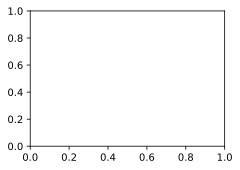

In [6]:
num_steps = 50
vocab_size = len(vocab)
train_bert(train_iter, net, loss, vocab_size, devices, num_steps)

In [27]:
import torch
a = torch.tensor([[1,2,3],[2,2,3],[1,22,3]], dtype=torch.float, requires_grad=True)
a.shape
b = torch.tensor([0,1,1], dtype=torch.long)
n = torch.nn.CrossEntropyLoss(reduction='none')
n(a,b)

tensor([2.4076, 1.5514, -0.0000], grad_fn=<NllLossBackward0>)

In [ ]:
import torch
a = torch.tensor([[1,2,3],[2,2,3],[1,22,3]], dtype=torch.float, requires_grad=True)
a.shape
b = torch.tensor([0,1,1], dtype=torch.long)
n = torch.nn.CrossEntropyLoss(reduction='none')
n(a,b)